This script provides functionality for an analysis of competitive machine learning on an example dataset. Here we iterate through multiple ML kernels and see how each one performs across a number of metrics. The intention is to comparatively evaluate different ML solutions to a given problem and identify an appropriate solution.

This script loads in an example datafile, allows for PCA to reduce dimensionality (though unnecessary here), then iterates over several ML kernels multiple times with k-fold sampling to produce aggregate fit scores.

In [1]:
__author__ = 'Ben Reuveni'
__date__ = '12/19/2019'
__email__ = 'ben.reuveni@gmail.com'

In [2]:
# Core packages
import numpy as np
import pandas as pd
import random

# Decomposition
from sklearn.decomposition import PCA

# ML Kernels
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm

# Sampling
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Metrics
from sklearn import metrics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score ,roc_curve,auc

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load a sample datafile
'''
The Banknote Dataset (http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt)
The Banknote Dataset involves predicting whether a given banknote is authentic given a number of measures taken from a photograph.

It is a binary (2-class) classification problem. The number of observations for each class is not balanced. There are 1,372 observations with 4 input variables and 1 output variable. The variable names are as follows:
'''
    
col_names = ['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Class']
data = pd.read_csv('X:\Google\Code\data_banknote_authentication.txt', names=col_names)
data.head()

,Variance,Skewness,Kurtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
# Allows for PCA functionality incase it's needed.
# In this case we select a number of components that account for 90% of the variance.
PCA_components = PCA(n_components=0.9)
# Perform it on all predictive data (outcome is in the final row)
PCA_data = pd.DataFrame(PCA_components.fit_transform(data.iloc[:, :-1]))
labels = data.loc[:,'Class']
PCA_data.head()

,0,1
0,-8.117954,-2.372615
1,-7.800124,-2.689555
2,3.690195,-4.372720
3,-9.908612,-0.978030
4,6.957545,-0.733813


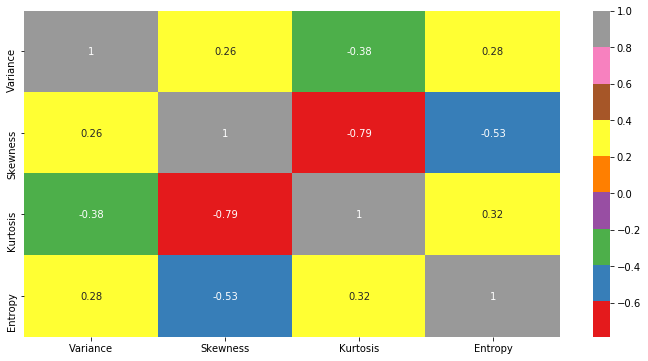

In [5]:
#Visualize a few dimensions

# sns.regplot(x='Variance', y='Skewness', data=data)
# sns.regplot(x='Variance', y='Kurtosis', data=data)
# sns.regplot(x='Variance', y='Entropy', data=data)

cor = data.iloc[:,:-1].corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor, cmap='Set1', annot=True)

In [6]:
## Initialize several ML kernels

rfc = RandomForestClassifier(n_estimators=100)
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
dtc = DecisionTreeClassifier(criterion="entropy")
bnb = BernoulliNB()
gnb = GaussianNB()
svc_rbf = svm.SVC(kernel='rbf', gamma="scale")
svc_lnr = svm.SVC(kernel='linear', gamma="scale")
lda = LinearDiscriminantAnalysis()

n_est = 50
max_smpl = 1.0
permutation_test = 0

In [11]:
model_names = ['rfc', 'xgb_model', 'dtc', 'bnb', 'gnb', 'svc_rbf', 'lda']
l = dict(zip(model_names, [[0,0,0] for i in range(8)]))
results = pd.DataFrame(l, index= ['Acc', 'Prec', 'f1'])
#results.index.name = 
results.head()

,rfc,xgb_model,dtc,bnb,gnb,svc_rbf,lda
Acc,0,0,0,0,0,0,0
Prec,0,0,0,0,0,0,0
f1,0,0,0,0,0,0,0


In [14]:
# we'll remove linear SVC because it's really slow in this instance.
models = [rfc, xgb_model, dtc, bnb, gnb, svc_rbf, lda]

# Do we want to use the PCA or original data?
d = PCA_data
d = data.iloc[:, :-1]

for i, bm in enumerate(models):
    model_name = str(bm).split('(')[0]
    print(f'Model: {model_name}')
    '''
    A permutation test checks whether the success of the current model does better than if the
    labels are scrambled. It's useful for unequal data. It makes sure the model isn't just
    learning the bias in the data (i.e. 70% of the data are in 1 category, just predict category 1
    70% of the time.)
    '''
    for permutation_test in [0]:#, 1]: 
        reps = 1
        if model_name == 'SVC':
            max_smpl = 1.0
            
        accuracy_rep_array = []
        precision_rep_array = []
        f1_rep_array = []
      
        for x in range(reps):
            print(f'Rep: {x}')

            if permutation_test == 1:
                np.random.shuffle(labels)

            # X_train, X_test, label_train, label_test = train_test_split(data_w_labels[:, 1:], labels,
            #                                                             test_size=.1, shuffle=True)
            X = d
            y = labels
            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(X, y)

            acc_array= []
            prec_array = []
            f1_array = []

            for train_index, test_index in skf.split(X, y):
                
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                label_train, label_test = y.iloc[train_index], y.iloc[test_index]             

                if model_name == 'LinearDiscriminantAnalysis':
                    lda_lsqr_shrink = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, label_train)
                    label_pred = lda_lsqr_shrink.predict(X_test)
                    acc_score = lda_lsqr_shrink.score(X_test, label_test)
                    prec = precision_score(label_test, label_pred, average='binary')
                    f1 = f1_score(label_test, label_pred, average='binary')
                
                else:  
                    # We will use bagging to increase the stability and accuracy of predictions.
                    # Good for messy data.
                
                    bag_model = BaggingClassifier(base_estimator=bm, n_estimators=n_est, max_samples=max_smpl,
                                                  bootstrap=True)  # random_state=0
                    bag_model = bag_model.fit(X_train, label_train)
                    label_pred = bag_model.predict(X_test)
                    acc_score = bag_model.score(X_test, label_test)
                    prec = precision_score(label_test, label_pred, average='binary')
                    f1 = f1_score(label_test, label_pred, average='binary')

                acc_array.append(acc_score)
                prec_array.append(prec)
                f1_array.append(f1)
                    
            accuracy_rep_array.append(np.mean(acc_array))
            precision_rep_array.append(np.mean(prec_array))
            f1_rep_array.append(np.mean(f1_array))

        a = round(np.mean(accuracy_rep_array), 4)
        p = round(np.mean(precision_rep_array), 4) 
        f = round(np.mean(f1_rep_array), 4)
        print(f"{model_name}:\nAccuracy: {a}\nPrecision: {p}\nf1 score: {f}\n\n")  
        results.iloc[:, i] = [a, p, f]

print(results)

Model: RandomForestClassifier
Rep: 0
RandomForestClassifier:
Accuracy: 0.9934
Precision: 0.9886
f1 score: 0.9926


Model: XGBClassifier
Rep: 0
XGBClassifier:
Accuracy: 0.9891
Precision: 0.987
f1 score: 0.9877


Model: DecisionTreeClassifier
Rep: 0
DecisionTreeClassifier:
Accuracy: 0.9934
Precision: 0.9902
f1 score: 0.9926


Model: BernoulliNB
Rep: 0
BernoulliNB:
Accuracy: 0.844
Precision: 0.8255
f1 score: 0.8242


Model: GaussianNB
Rep: 0
GaussianNB:
Accuracy: 0.8389
Precision: 0.8388
f1 score: 0.8126


Model: SVC
Rep: 0
SVC:
Accuracy: 0.9985
Precision: 0.9967
f1 score: 0.9984


Model: LinearDiscriminantAnalysis
Rep: 0
LinearDiscriminantAnalysis:
Accuracy: 0.9767
Precision: 0.9503
f1 score: 0.9745


         rfc  xgb_model     dtc     bnb     gnb  svc_rbf     lda
Acc   0.9934     0.9891  0.9934  0.8440  0.8389   0.9985  0.9767
Prec  0.9886     0.9870  0.9902  0.8255  0.8388   0.9967  0.9503
f1    0.9926     0.9877  0.9926  0.8242  0.8126   0.9984  0.9745



Full data:

         rfc  xgb_model     dtc     bnb     gnb  svc_rbf     lda
Acc   0.9934     0.9891  0.9934  0.8440  0.8389   0.9985  0.9767
Prec  0.9886     0.9870  0.9902  0.8255  0.8388   0.9967  0.9503
f1    0.9926     0.9877  0.9926  0.8242  0.8126   0.9984  0.9745


PCA:
        rfc  xgb_model     dtc     bnb     gnb  svc_rbf     lda
Acc   0.8557     0.8338  0.8564  0.6873  0.7179   0.8178  0.7369
Prec  0.8312     0.7957  0.8437  0.6411  0.7272   0.7764  0.7393
f1    0.8379     0.8187  0.8364  0.6569  0.6492   0.8020  0.6808
